In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import sys
Path = '/remote/tychodata/ftairli/work/Projects/FD_Reconstruction/Code/'
if Path not in sys.path:
    sys.path.append(Path)
import ManageData as MD

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns

In [2]:
Model_Name_List = ['ActivePixel', 'Charge_Only','PulseDuration','Time_Only','Time_Charge','Combined']


Models   = {Model_Name: torch.load(f'Model_ImportanceAnalysis_{Model_Name}.pt') for Model_Name in Model_Name_List}
Trackers = {Model_Name: torch.load(f'Model_ImportanceAnalysis_{Model_Name}_Tracker.pt') for Model_Name in Model_Name_List} 


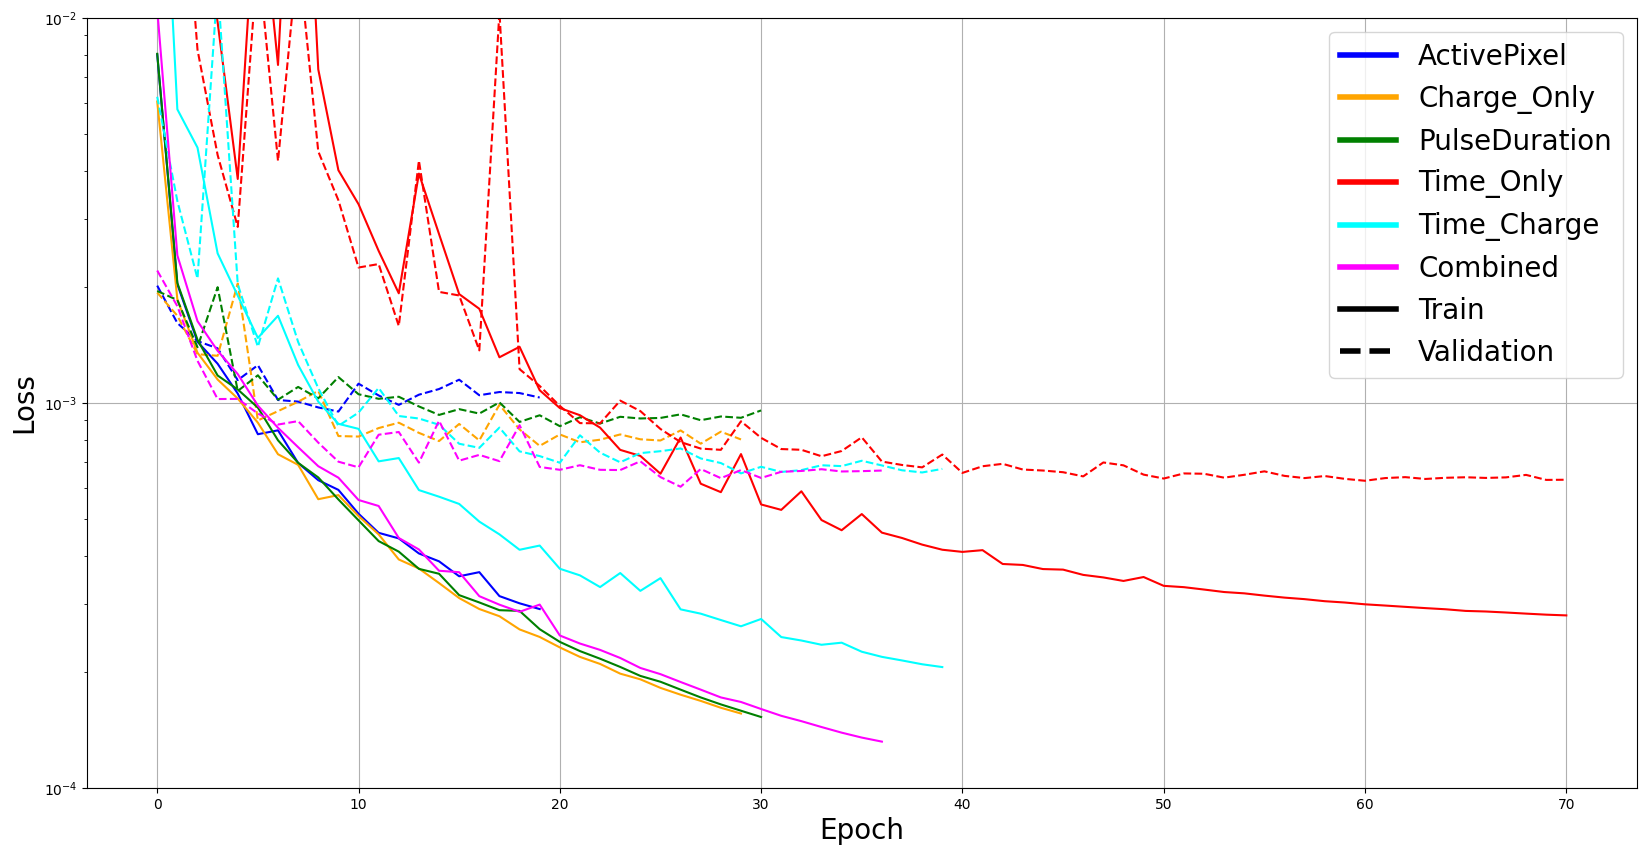

In [3]:
colors = {Model_Name : color for Model_Name,color in zip(Model_Name_List,['blue', 'orange', 'green', 'red','cyan','magenta'])}
plt.figure(figsize=(20,10))
for Model_Name in Model_Name_List:
    plt.plot(Trackers[Model_Name].EpochLoss   ,color=colors[Model_Name])
    plt.plot(Trackers[Model_Name].EpochValLoss,color=colors[Model_Name],linestyle='dashed')
custom_lines = [Line2D([0], [0], color=colors[Model_Name], lw=4) for Model_Name in Model_Name_List]
custom_lines.append(Line2D([0], [0], color='black', lw=4))
custom_lines.append(Line2D([0], [0], color='black', lw=4,linestyle='dashed'))

plt.legend(custom_lines, Model_Name_List+['Train','Validation'],fontsize=20)
plt.xlabel('Epoch',fontsize=20)
plt.ylabel('Loss',fontsize=20)
plt.yscale('log')
plt.ylim(1e-4,1e-2)
plt.grid()
plt.show()

In [4]:
datapath = '/remote/tychodata/ftairli/work/Projects/FD_Reconstruction/Data/NormData/'
GenGeometry = torch.load(f'{datapath}GenGeometry_test.pt')
RecGeometry = torch.load(f'{datapath}RecGeometry_test.pt')
Main        = torch.load(f'{datapath}Main_test.pt')
PixDur      = torch.load(f'{datapath}PixDur_test.pt')
Meta        = torch.load(f'{datapath}Meta_test.pt')
Main = Main[:,[0,1],...]

Main[torch.isinf(Main)] = 0.0

Want_N_Pixels = 10
Npix = (Main[:,1,:,:] !=0 ).float().sum(dim=[1,2]).cpu().numpy()
cut = Npix < Want_N_Pixels
Main = Main[cut]
GenGeometry = GenGeometry[cut]
RecGeometry = RecGeometry[cut]
PixDur = PixDur[cut]
Meta = Meta[cut]

print(f'Number of Events: {len(Main)}')


TruthSDP = GenGeometry[:,[3,4]]
RecSDP   = RecGeometry[:,[3,4]]
PredSDPs = {} 

Main[:,0,:,:] = MD.PixTime_to_net(Main[:,0,:,:])
Main[:,1,:,:] = MD.PixSig_to_net(Main[:,1,:,:])
PixDur = MD.PixDur_to_net(PixDur)
Main = Main.to('cuda')
PixDur = PixDur.to('cuda')


for Model_Name in Model_Name_List:
    Model_PredSDP = torch.zeros_like(TruthSDP)
    Model = Models[Model_Name].to('cuda')
    Model.eval()
    with torch.no_grad():
        for i in range(len(Main)):
            print(f'Model: {Model_Name} : {i}',end='\r')
            if Model_Name in ['Combined','PulseDuration']:
                Model_PredSDP[i,:],State = Model(torch.cat((Main[i],PixDur[i])).unsqueeze(0))
            else:
                Model_PredSDP[i,:],State = Model(Main[i].unsqueeze(0))
    print()
    Model_PredSDP = Model_PredSDP.cpu()
    Model_PredSDP[:,0] = MD.Phi_to_val(Model_PredSDP[:,0])
    Model_PredSDP[:,1] = MD.Theta_to_val(Model_PredSDP[:,1])
    PredSDPs[Model_Name] = Model_PredSDP



# Normalise SDP
# Phi
TruthSDP[:,0] = MD.Phi_to_mirror(TruthSDP[:,0],Meta[:,9])
RecSDP[:,0]   = MD.Phi_to_mirror(RecSDP[:,0],Meta[:,9])
# Pred Phi already in Mirror
TruthSDP[:,0] = MD.Phi_to_net(TruthSDP[:,0])
RecSDP[:,0]   = MD.Phi_to_net(RecSDP[:,0])
# Phi SDP already in Net

# Theta
TruthSDP[:,1] = MD.Theta_to_net(TruthSDP[:,1])
RecSDP[:,1]   = MD.Theta_to_net(RecSDP[:,1])
# Pred Theta already in Net


# UnNet Everything

# Phi
TruthSDP[:,0] = MD.Phi_to_val(TruthSDP[:,0])
RecSDP[:,0]   = MD.Phi_to_val(RecSDP[:,0])


# Theta
TruthSDP[:,1] = MD.Theta_to_val(TruthSDP[:,1])
RecSDP[:,1]   = MD.Theta_to_val(RecSDP[:,1])




# Delete Infs and nans

mask = torch.isnan(TruthSDP[:,0]) | torch.isnan(TruthSDP[:,1]) | torch.isnan(RecSDP[:,0]) | torch.isnan(RecSDP[:,1]) 
for Model_Name in Model_Name_List:
    mask = mask | torch.isnan(PredSDPs[Model_Name][:,0]) | torch.isnan(PredSDPs[Model_Name][:,1])

TruthSDP = TruthSDP[~mask]
RecSDP   = RecSDP[~mask]
for Model_Name in Model_Name_List:
    PredSDPs[Model_Name] = PredSDPs[Model_Name][~mask]


Number of Events: 1032
Model: ActivePixel : 1031
Model: Charge_Only : 1031
Model: PulseDuration : 1031
Model: Time_Only : 1031
Model: Time_Charge : 1031
Model: Combined : 1031


In [5]:

AbsErrors_Phi = {}
AbsErrors_Theta = {}

Means_Phi     = {}
Means_Theta   = {}


for Model_Name in Model_Name_List:
    AbsErrors_Phi[Model_Name]   = torch.abs(PredSDPs[Model_Name][:,0] - TruthSDP[:,0])
    Means_Phi[Model_Name]       = torch.mean(AbsErrors_Phi[Model_Name])
    AbsErrors_Theta[Model_Name] = torch.abs(PredSDPs[Model_Name][:,1] - TruthSDP[:,1])
    Means_Theta[Model_Name]     = torch.mean(AbsErrors_Theta[Model_Name])
    AbsErrors_Phi[Model_Name]   = AbsErrors_Phi[Model_Name].numpy()
    AbsErrors_Theta[Model_Name] = AbsErrors_Theta[Model_Name].numpy()
    Means_Phi[Model_Name]       = Means_Phi[Model_Name].numpy()
    Means_Theta[Model_Name]     = Means_Theta[Model_Name].numpy()


Model: ActivePixel
     : Phi   68th % : 1.00986
     : Theta 68th % : 3.65902

Model: Charge_Only
     : Phi   68th % : 0.99059
     : Theta 68th % : 3.66658

Model: PulseDuration
     : Phi   68th % : 1.05582
     : Theta 68th % : 3.86757

Model: Time_Only
     : Phi   68th % : 1.01854
     : Theta 68th % : 3.85539

Model: Time_Charge
     : Phi   68th % : 0.94511
     : Theta 68th % : 3.61454

Model: Combined
     : Phi   68th % : 1.03565
     : Theta 68th % : 3.76327



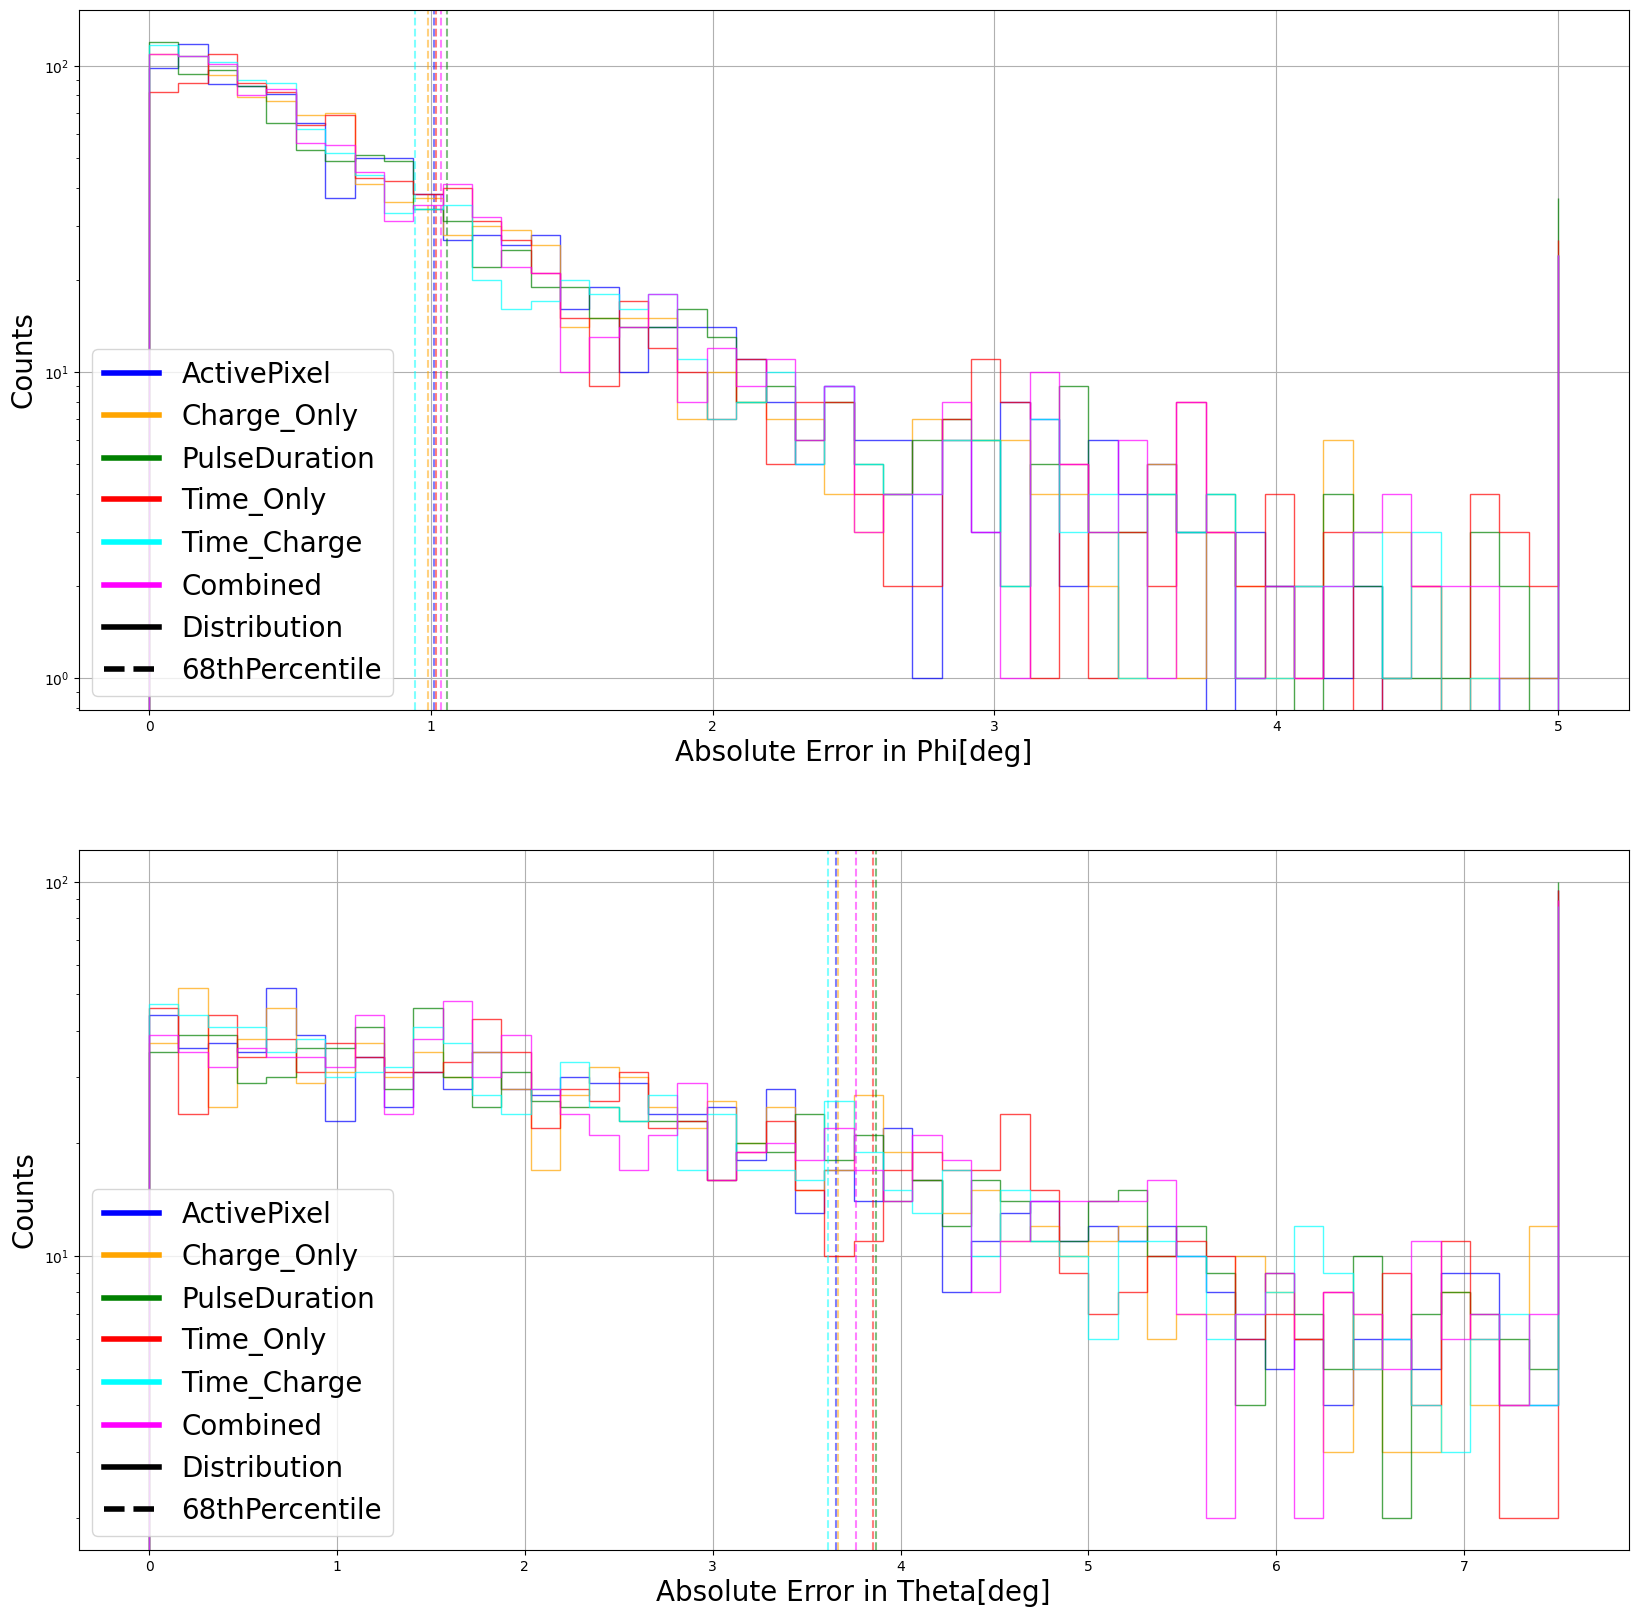

In [10]:
fig,ax = plt.subplots(ncols = 1,nrows = 2,figsize=(20,20))
h1 = 1000
h2 = 800

Nbins = 50
bins = np.linspace(0,5,Nbins-1)
bins = np.append(bins,[np.inf])
for i,Model_Name in enumerate(Model_Name_List):
    PhiBinVals = ax[0].hist(AbsErrors_Phi  [Model_Name]*180/np.pi,bins=bins,color=colors[Model_Name],alpha=0.7,histtype = 'step')
    ThetaBinsVals = ax[1].hist(AbsErrors_Theta[Model_Name]*180/np.pi,bins=bins*1.5,color=colors[Model_Name],alpha=0.7,histtype = 'step')

    # print(f'{Model_Name} : In Last Phi Bin : {PhiBinVals[0][-1]}')
    # print(f'{Model_Name} : In Last Theta Bin : {ThetaBinsVals[0][-1]}')
    
    # Print Means and 68th Percentiles to 5 sig figs
    print(f'Model: {Model_Name}')
    # print(f'     : Phi   Mean   : {np.round(Means_Phi[Model_Name]*180/np.pi,5)}')
    # print(f'     : Theta Mean   : {np.round(Means_Theta[Model_Name]*180/np.pi,5)}')
    print(f'     : Phi   68th % : {np.round(np.percentile(AbsErrors_Phi[Model_Name]*180/np.pi,68),5)}')
    print(f'     : Theta 68th % : {np.round(np.percentile(AbsErrors_Theta[Model_Name]*180/np.pi,68),5)}')
    print()
    


    reso = np.percentile(AbsErrors_Phi[Model_Name]*180/np.pi,68)
    ax[0].axvline(reso,color=colors[Model_Name],linestyle='dashed',alpha =  0.5)
    reso = np.percentile(AbsErrors_Theta[Model_Name]*180/np.pi,68)
    ax[1].axvline(reso,color=colors[Model_Name],linestyle='dashed',alpha =  0.5)

ax[0].legend(custom_lines, Model_Name_List+['Distribution','68thPercentile'],fontsize=20)
ax[1].legend(custom_lines, Model_Name_List+['Distribution','68thPercentile'],fontsize=20)
ax[0].set_xlabel('Absolute Error in Phi[deg]',fontsize=20)
ax[1].set_xlabel('Absolute Error in Theta[deg]',fontsize=20)
ax[0].set_ylabel('Counts',fontsize=20)
ax[1].set_ylabel('Counts',fontsize=20)
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[0].grid()
ax[1].grid()

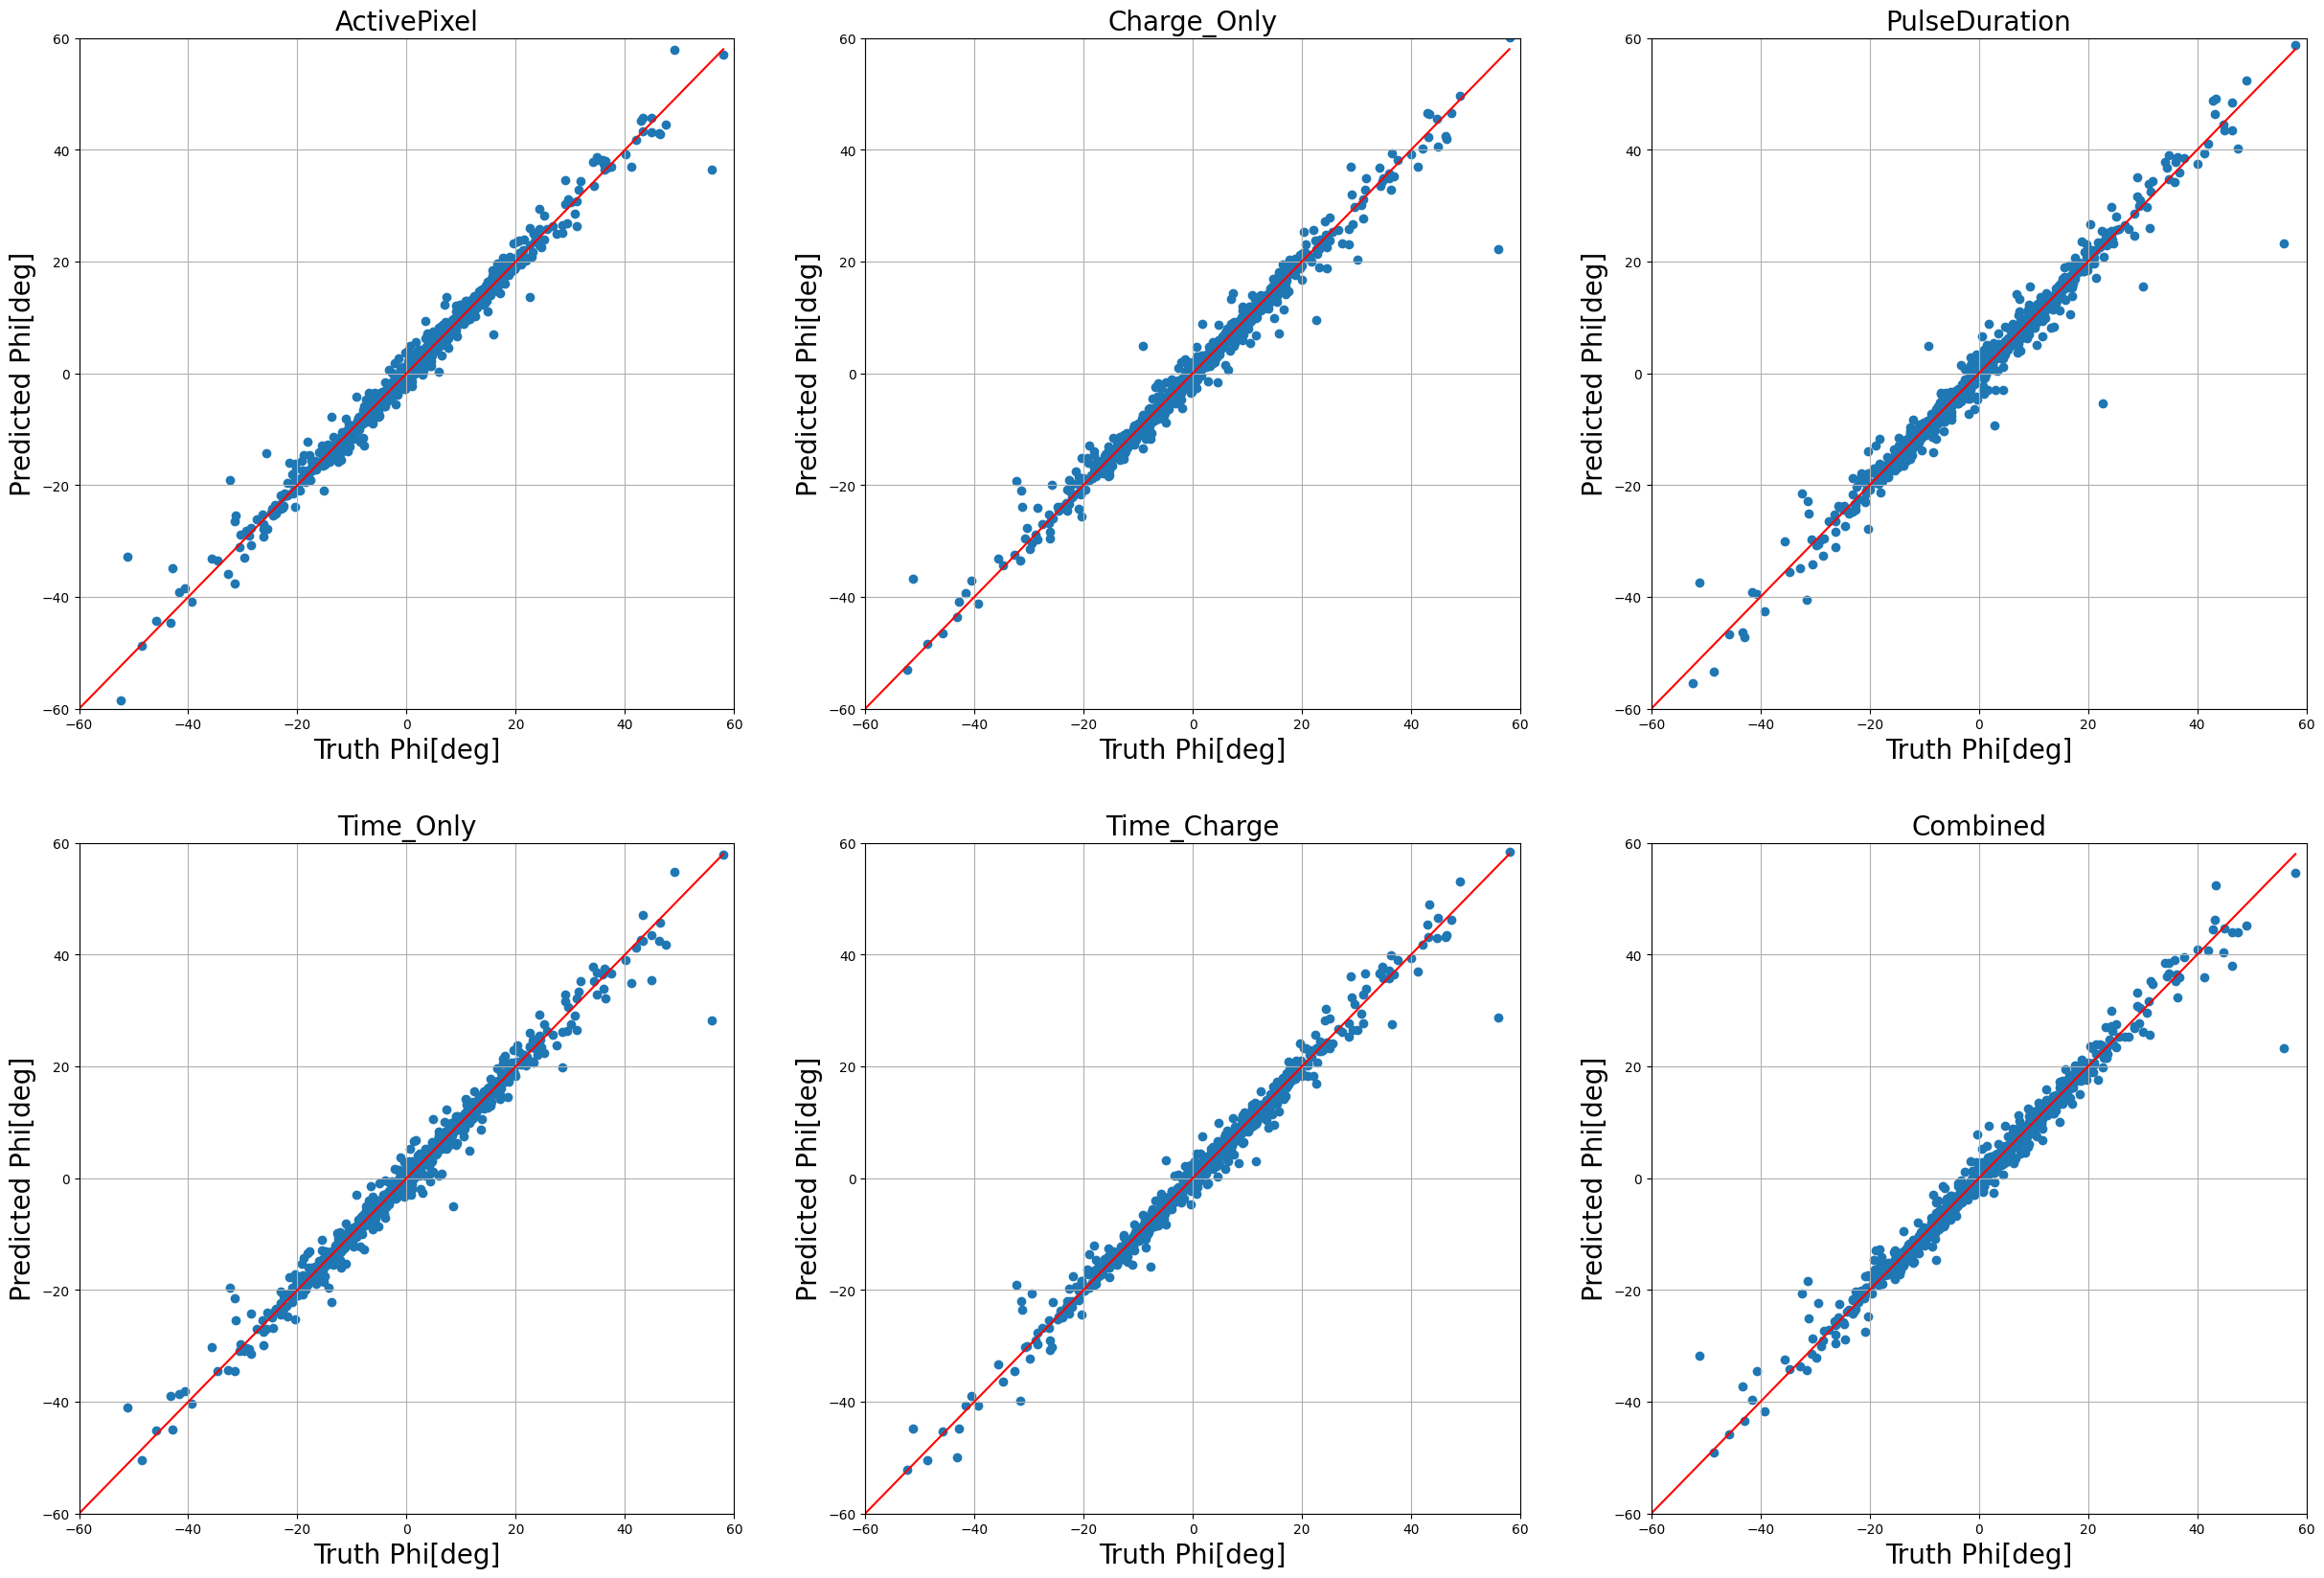

In [7]:
fig, axs = plt.subplots(ncols = 3, nrows=2, figsize=(30,20))

for i,Model_Name in enumerate(Model_Name_List):
    ax = axs[i//3,i%3]
    ax.scatter(TruthSDP[:,0]*180/np.pi,PredSDPs[Model_Name][:,0]*180/np.pi)
    ax.plot([min(TruthSDP[:,0]*180/np.pi),max(TruthSDP[:,0]*180/np.pi)],[min(TruthSDP[:,0]*180/np.pi),max(TruthSDP[:,0]*180/np.pi)],color='red')
    ax.set_xlabel('Truth Phi[deg]',fontsize=20)
    ax.set_ylabel('Predicted Phi[deg]',fontsize=20)
    ax.set_title(f'{Model_Name}',fontsize=20)
    ax.set_xlim(-60,60)
    ax.set_ylim(-60,60)
    ax.grid()

    

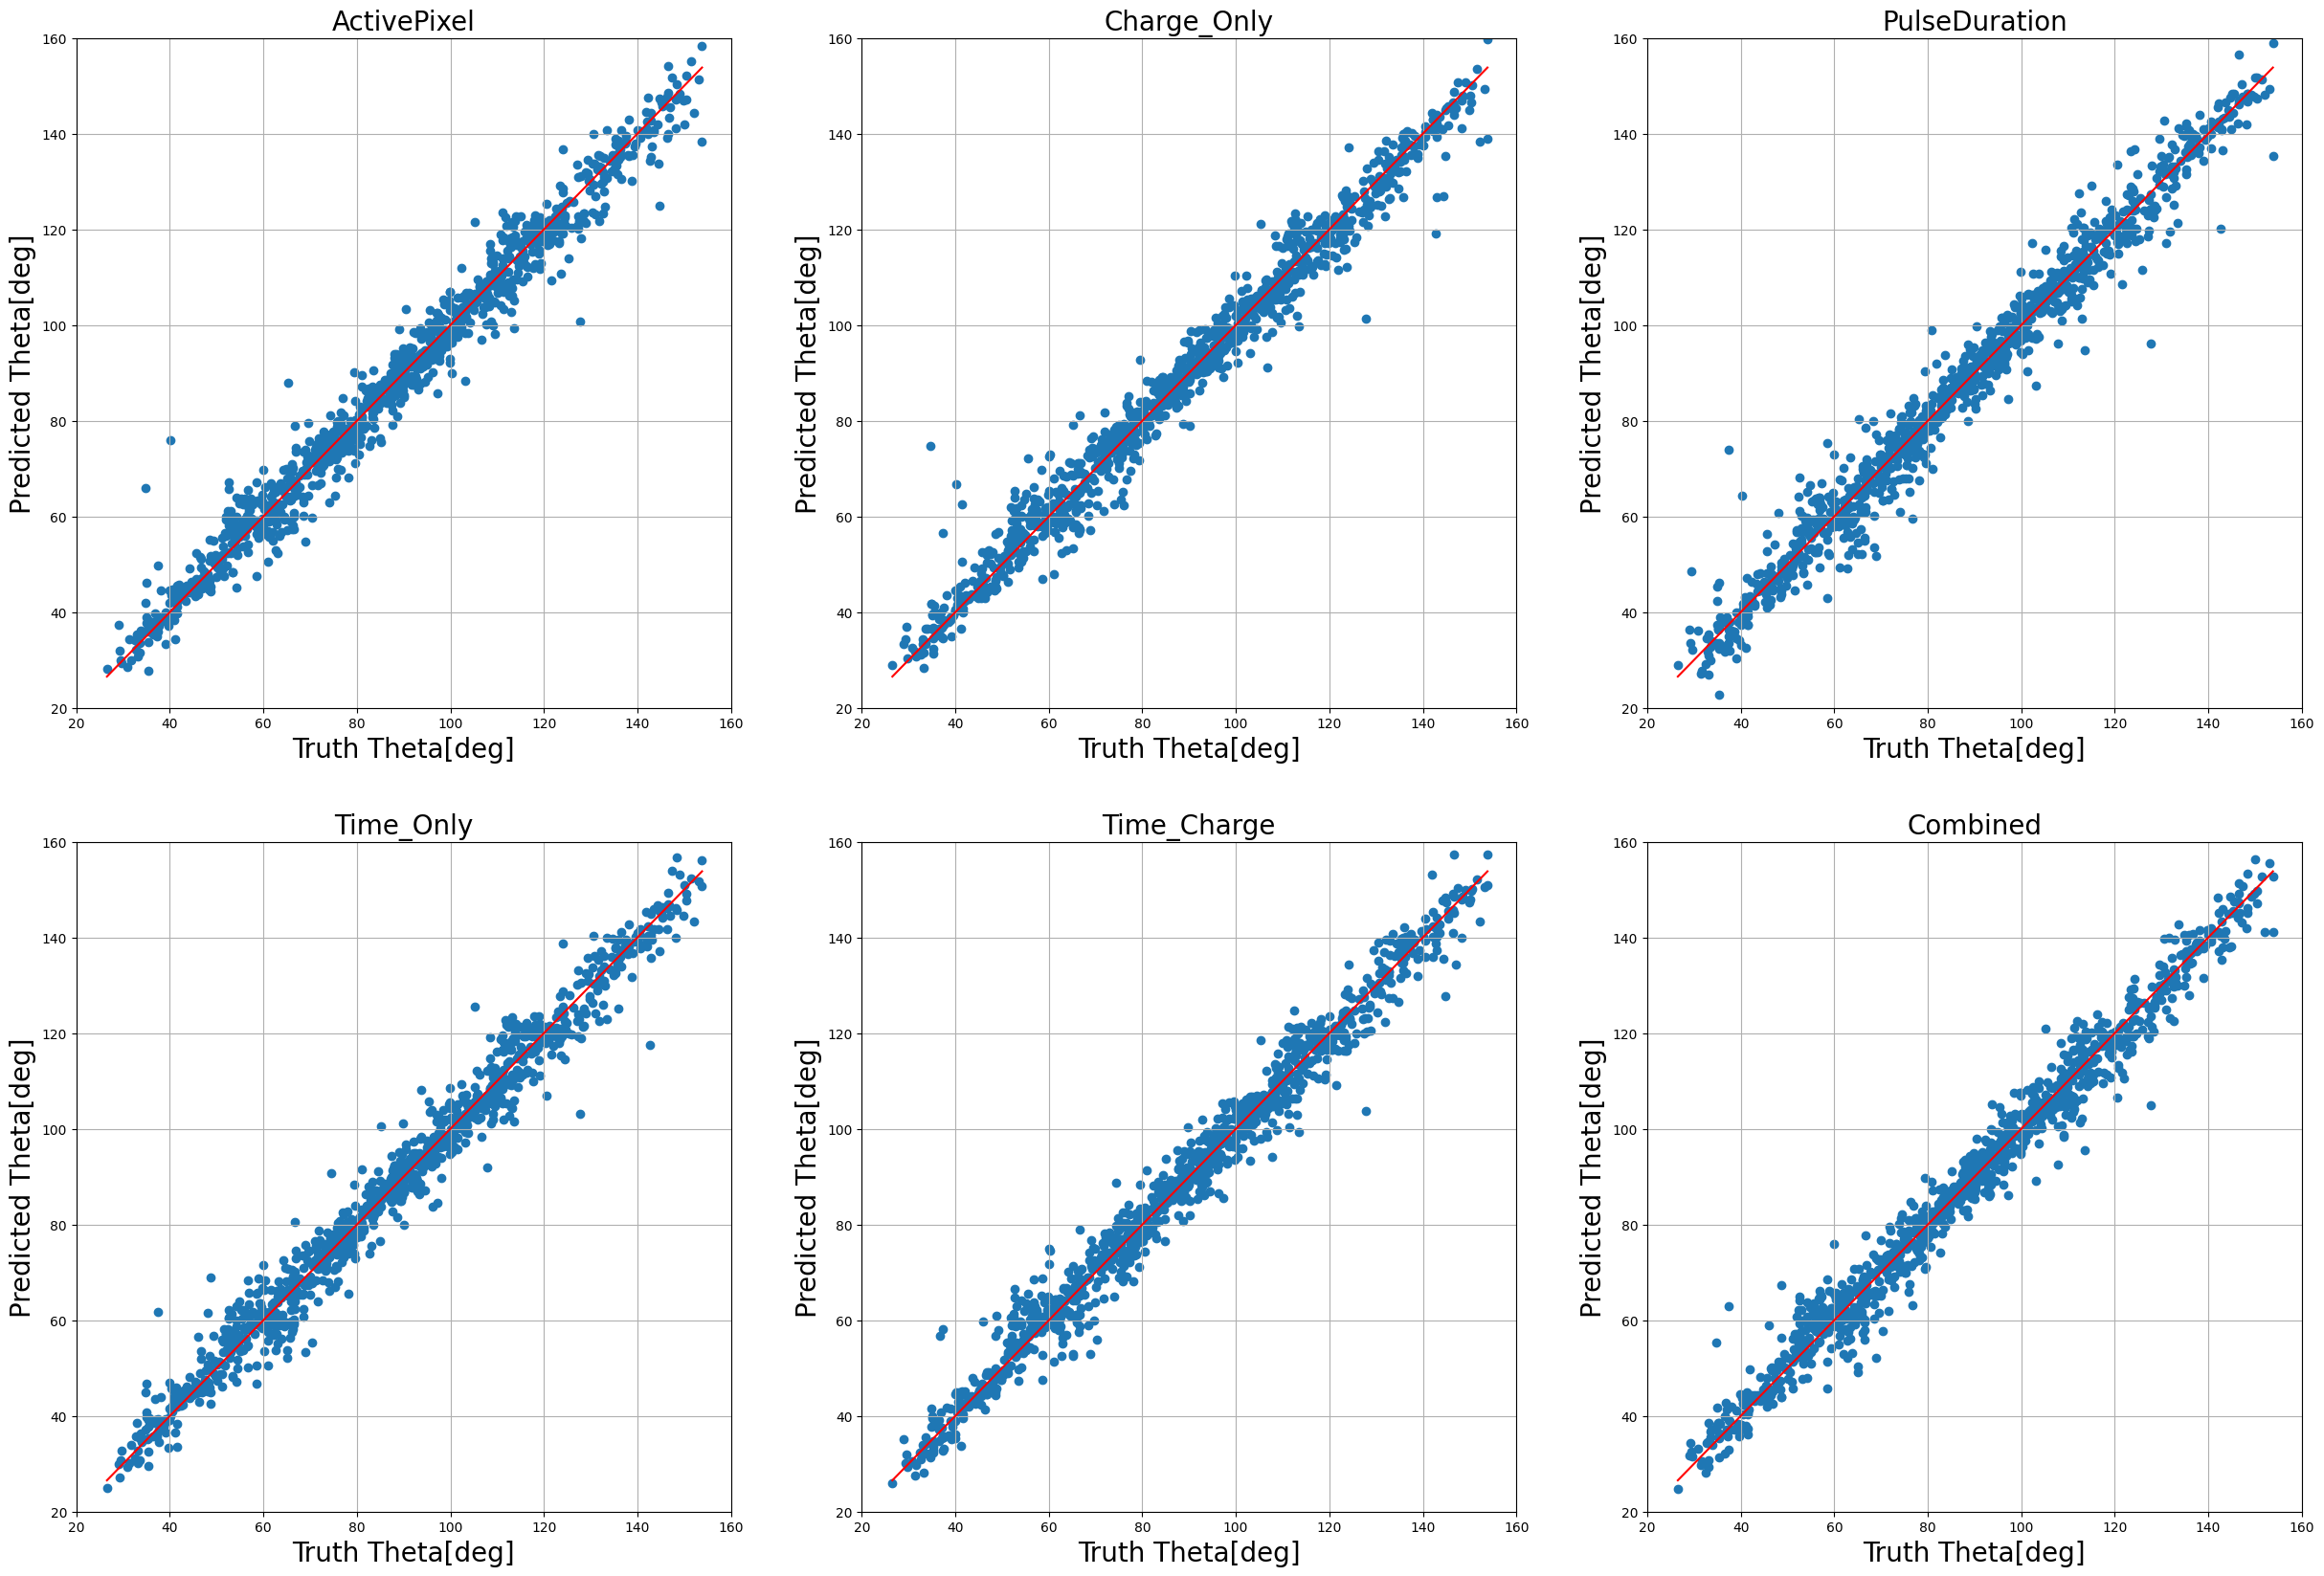

In [8]:
fig, axs = plt.subplots(ncols = 3, nrows=2, figsize=(30,20))

for i,Model_Name in enumerate(Model_Name_List):
    ax = axs[i//3,i%3]
    ax.scatter(TruthSDP[:,1]*180/np.pi,PredSDPs[Model_Name][:,1]*180/np.pi)
    ax.plot([min(TruthSDP[:,1]*180/np.pi),max(TruthSDP[:,1]*180/np.pi)],[min(TruthSDP[:,1]*180/np.pi),max(TruthSDP[:,1]*180/np.pi)],color='red')
    ax.set_xlabel('Truth Theta[deg]',fontsize=20)
    ax.set_ylabel('Predicted Theta[deg]',fontsize=20)
    ax.set_title(f'{Model_Name}',fontsize=20)
    ax.set_xlim(20,160)
    ax.set_ylim(20,160)
    ax.grid()

    

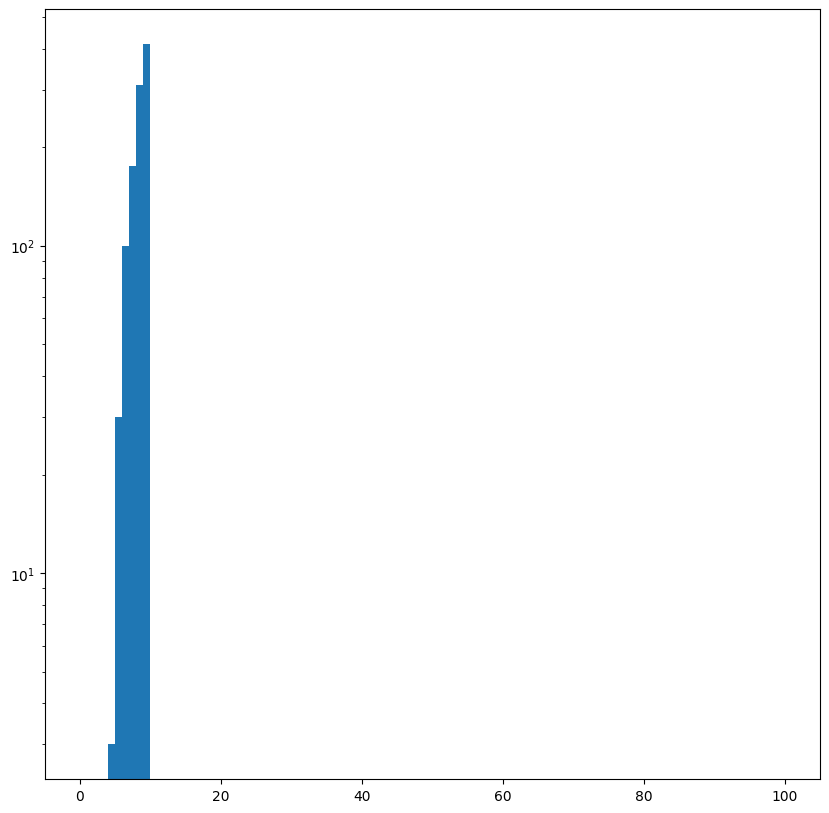

Number of Events with less than 10 pixels : 1032


In [9]:
Npix = (Main[:,1,:,:] !=0 ).float().sum(dim=[1,2]).cpu().numpy()
plt.figure(figsize=(10,10))
plt.hist(Npix,bins=range(101))
plt.yscale('log')
plt.show()

cut = Npix < 10
print(f'Number of Events with less than 10 pixels : {cut.sum()}')

In [ ]:
LowPixMain = Main[cut]

